In [1]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg

from sin_cos_wave import sin_wave, cos_wave, sample_sequence
from update import _update_parameter
from predict import _predict, AR

In [2]:
#X[Time, 4, N]
#0:T_f temprature of front server i
#1:T_b temprature of behind server i
#2:U horizontal airflow speed
#3:W watts generated by server i
#V_fl[Time, 1]
#V_fl vertical airflow speed of zone below the vent

time=500
N=5
X = sample_sequence(time, 4, N)
V_fl = sample_sequence(time, 1, 1).reshape(time, 1)
print('X shape', X.shape)
print('V_fl shape', V_fl.shape)

X shape (500, 4, 5)
V_fl shape (500, 1)


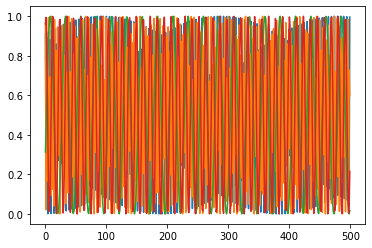

In [3]:
#minmax for avoid divergent
from sklearn.preprocessing import MinMaxScaler
mmscaler = MinMaxScaler(feature_range=(0, 1), copy=True)
V_fl = mmscaler.fit_transform(V_fl)
for i in range(N):
	X[:,:,i] = mmscaler.fit_transform(X[:,:,i])

# plt.plot(V_fl)
plt.plot(X[:,:,0])

In [11]:
#forgetting factor
FF=0.001
#training window size
T_w=10
#predict time
T_p=2
#iteration of parameter update
n_iter=10

class ThermoCast():
	def __init__(self, i):
		if i<=0 or i>=N:
			print('make sure 0<i<N')
		self.theta0 = ThermoTheta(i, position=0)
		self.theta_down = ThermoTheta(i, position=-1)
		self.theta_top = ThermoTheta(i, position=1)
		self.sever_index = i

	def train(self, X, V_fl):
		print('update theta')
		self.theta0.update(X, V_fl)
		self.theta_down.update(X, V_fl)
		self.theta_top.update(X, V_fl)

		print('ar model for V_fl')
		self.ar_V_fl = AR(V_fl.reshape(-1), p=2)

	def predict(self, X, V_fl, T_p):
		predict=_predict(self, X, V_fl, T_p)
		return predict

class ThermoTheta():
	def __init__(self, i, position):
		self.a = np.random.randn()
		self.b1 = np.random.randn()
		self.b2 = np.random.randn()
		self.b3 = np.random.randn()
		self.b4 = np.random.randn()
		self.f1 = np.random.randn()
		self.f2 = np.random.randn()
		self.f3 = np.random.randn()
		self.f4 = np.random.randn()
		self.sever_index = i
		self.position = position

		if position==-1:
			self.b3 = 0
			self.f4 = 0
		if position==1:
			self.b4 = 0

	def update(self, X, V_fl):
		i = self.sever_index + self.position
		for _ in range(n_iter):
			_update_parameter(i, X, V_fl, self)


In [15]:
X_window = X[:T_w]
V_fl_window = V_fl[:T_w]
#( 1<i<N ) top and bottom are special case, so not completed yet.
model = ThermoCast(i=3)
model.train(X_window, V_fl_window)
pred = model.predict(X_window, V_fl_window, T_p)
print(pred.shape)

make sure 0<i<N
update theta
ar model for V_fl
(12, 4, 5)


/opt/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


In [16]:
print(vars(model.theta0))
print(vars(model.theta_down))
print(vars(model.theta_top))

{'a': -0.18276503793713392, 'b1': 0.5007058362575479, 'b2': 0.21319753809217884, 'b3': 0.2643228439483875, 'b4': -0.05512150295816542, 'f1': 0.16612750509931828, 'f2': 0.05290820368743761, 'f3': 0.3039108075535539, 'f4': 0.13463946863689089, 'sever_index': 0, 'position': 0}
{'a': 0.3377873417971551, 'b1': 0.3036063059576665, 'b2': -0.06263247813605358, 'b3': 0, 'b4': 0.025015440476588692, 'f1': 0.1549986493696393, 'f2': 0.04250081079304069, 'f3': 0.00981824241283165, 'f4': 0, 'sever_index': 0, 'position': -1}
{'a': -0.4459917018075593, 'b1': 0.5875440406641949, 'b2': 0.4161280048605585, 'b3': 0.10345703475542771, 'b4': 0, 'f1': 0.5362621959896461, 'f2': 0.21180423916035862, 'f3': -0.08437297923449309, 'f4': 0.2226564168166381, 'sever_index': 0, 'position': 1}


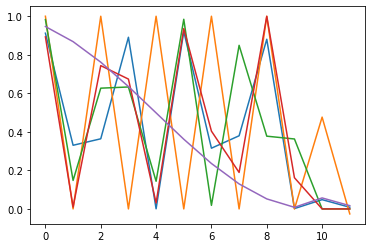

In [17]:
plt.plot(pred[:,0,:])